# MNIST Digit Recognizer
**"Hello World"**.
This notebook will help in understanding the basics of Computer Vision and design a CNN model to identify hand written numbers with high accuracy.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

# Data Reading and Cleaning

In [2]:
#Training Dataset
train=pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
print("Training Dataset Shape:",train.shape)
train.head()

Training Dataset Shape: (42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
#Testing Dataset
test=pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
print('Test Dataset Shape:',test.shape)
test.head()

Test Dataset Shape: (28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#Extracting the dependent and independent variables
y=train['label'].values #To be predicted
x=train.drop('label',axis=1).values #Independent Variables
print('Variables Shape:',x.shape)
print('Labels Shape:',y.shape)

Variables Shape: (42000, 784)
Labels Shape: (42000,)


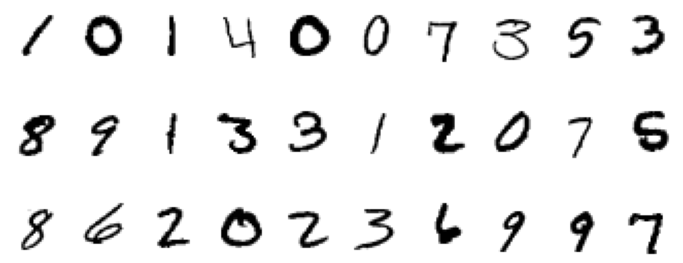

In [5]:
#Displaying some images from the dataset
import matplotlib.pyplot as plt
x=x.reshape(x.shape[0],28,28)
fig=plt.figure(figsize=(12,5))
for i in range(30):
    plt.subplot(3,10,i+1)
    plt.axis('off')
    plt.imshow(x[i],cmap=plt.cm.binary)

In [6]:
#Reshaping and Normalization
from keras.utils.np_utils import to_categorical

#Reshape images to input into CNN layers as a 4D Tensor
x=x.reshape(-1,28,28,1)
test=test.values.reshape(-1,28,28,1)
#Normalization
x=x/255
test=test/255
#One Hot Encoding the labels
y=to_categorical(y)

# CNN Model

In [7]:
#Data Augmentation to increase number of input images
from keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

In [8]:
#CNN Ensemble Models
#To learn about deep learning ensemble models:
# https://machinelearningmastery.com/ensemble-methods-for-deep-learning-neural-networks/
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,GlobalAveragePooling2D,MaxPool2D,Flatten,BatchNormalization

ensem=10
model=[0]*ensem
for i in range(ensem):
    model[i]=Sequential()
    model[i].add(Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',input_shape=(28,28,1)))
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu'))
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu'))
    model[i].add(BatchNormalization())
    model[i].add(MaxPool2D(2,2))
    model[i].add(Dropout(0.2))

    model[i].add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
    model[i].add(BatchNormalization())
    model[i].add(MaxPool2D(2,2))
    model[i].add(Dropout(0.2))

    model[i].add(GlobalAveragePooling2D())
    model[i].add(Dense(128,activation='relu'))
    model[i].add(Dropout(0.2))
    model[i].add(Dense(10,activation='softmax'))
    
    model[i].compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [9]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

callback=tf.keras.callbacks.EarlyStopping(monitor='accuracy',min_delta=0,patience=5,mode='auto',restore_best_weights=True,verbose=0)
lrs=tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

history=[0]*ensem
for i in range(ensem):
    train_x,valid_x,train_y,valid_y=train_test_split(x,y,test_size=0.2)
    history[i]=model[i].fit_generator(train_datagen.flow(train_x,train_y,batch_size=128),
                      epochs=100,
                      steps_per_epoch=train_x.shape[0]//128,
                      verbose=0,
                      validation_data=(valid_x,valid_y),
                      validation_steps=valid_x.shape[0]//128,
                      callbacks=[callback,lrs])
    print('Model {}: Epochs=100, Train_Accuracy:{}, Val_Accuracy:{}'.format(i+1,max(history[i].history['accuracy']),max(history[i].history['val_accuracy'])))

Model 1: Epochs=100, Train_Accuracy:0.9959667921066284, Val_Accuracy:0.9957143068313599
Model 2: Epochs=100, Train_Accuracy:0.9969227910041809, Val_Accuracy:0.9955952167510986
Model 3: Epochs=100, Train_Accuracy:0.9962058067321777, Val_Accuracy:0.9946428537368774
Model 4: Epochs=100, Train_Accuracy:0.9967734217643738, Val_Accuracy:0.995119035243988
Model 5: Epochs=100, Train_Accuracy:0.994293749332428, Val_Accuracy:0.9957143068313599
Model 6: Epochs=100, Train_Accuracy:0.9969825744628906, Val_Accuracy:0.9941666722297668
Model 7: Epochs=100, Train_Accuracy:0.9975800514221191, Val_Accuracy:0.9952380657196045
Model 8: Epochs=100, Train_Accuracy:0.9951601624488831, Val_Accuracy:0.9957143068313599
Model 9: Epochs=100, Train_Accuracy:0.9965941905975342, Val_Accuracy:0.9959523677825928
Model 10: Epochs=100, Train_Accuracy:0.9973709583282471, Val_Accuracy:0.9963095188140869


# Plotting

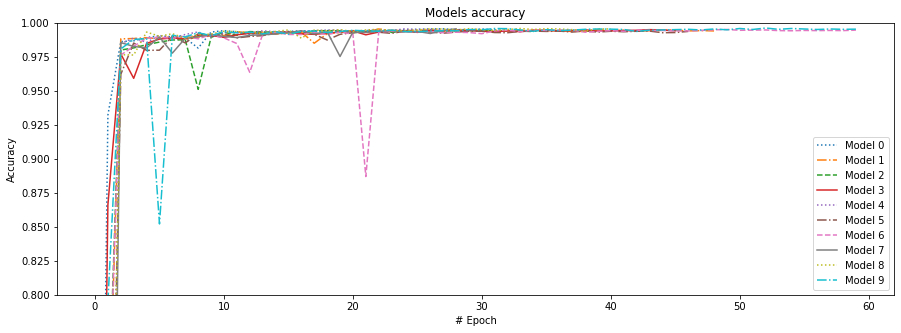

In [10]:
#Models Accuracy
import matplotlib.pyplot as plt

styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']
names=['Model {}'.format(i) for i in range(ensem)]
plt.figure(figsize=(15,5))
for i in range(ensem):
    plt.plot(history[i].history['val_accuracy'],linestyle=styles[i])
plt.title('Models accuracy')
plt.ylabel('Accuracy')
plt.xlabel('# Epoch')
plt.legend(names, loc='lower right')
axes = plt.gca()
axes.set_ylim([0.8,1])
plt.show()

* All the models follow a similar trend for Validation Accuracy

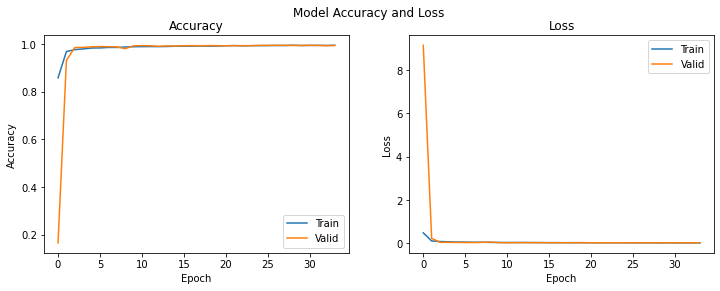

In [11]:
#Plotting the loss and accuracy for the first model.
#All the modesl follow a similar trend

def plot_model(history):
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,4))
    fig.suptitle('Model Accuracy and Loss')

    ax1.plot(history[0].history['accuracy'])
    ax1.plot(history[0].history['val_accuracy'])
    ax1.title.set_text('Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train','Valid'],loc=4)

    ax2.plot(history[0].history['loss'])
    ax2.plot(history[0].history['val_loss'])
    ax2.title.set_text('Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train','Valid'],loc=1)

    fig.show()

plot_model(history)

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       869
           1       1.00      0.99      1.00       962
           2       1.00      1.00      1.00       799
           3       1.00      1.00      1.00       893
           4       1.00      1.00      1.00       820
           5       1.00      1.00      1.00       773
           6       1.00      1.00      1.00       844
           7       0.99      1.00      1.00       850
           8       1.00      1.00      1.00       767
           9       1.00      1.00      1.00       823

    accuracy                           1.00      8400
   macro avg       1.00      1.00      1.00      8400
weighted avg       1.00      1.00      1.00      8400



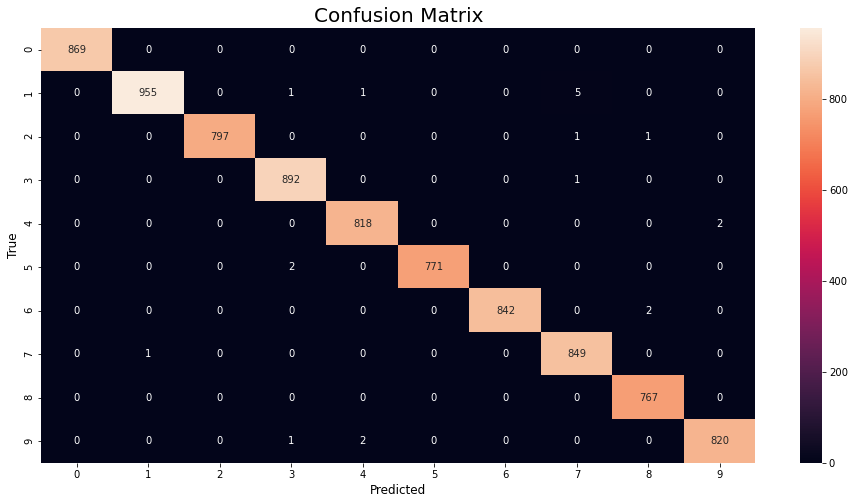

In [12]:
#Classification Report and Confusion Matrix for the first model

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

#Predicting values from the validation dataset and one hot encoding the predicted and true labels
y_pred=model[0].predict(valid_x)
y_pred_classes=np.argmax(y_pred, axis=1)
y_true=np.argmax(valid_y, axis=1)

#Classification Report
print('Classification Report')
report=classification_report(y_true, y_pred_classes)
print(report)

#Computuing and Plotting Confusion Matrix
confusion_mtx=confusion_matrix(y_true, y_pred_classes)
f,ax=plt.subplots(figsize=(16,8))
sns.heatmap(confusion_mtx,annot=True,fmt='')
plt.xlabel("Predicted",size=12)
plt.ylabel("True",size=12)
plt.title("Confusion Matrix",size=20)
plt.show()

* Most of the values are correctly predicted with high precision
* Highest error rate is between 7-2 and 4-9

# Submission

In [13]:
prediction=np.zeros((test.shape[0],10)) 
for i in range(ensem):
    prediction=prediction+model[i].predict(test)
prediction=np.argmax(prediction,axis = 1)
prediction=pd.Series(prediction,name="Label")

submission = pd.concat([pd.Series(range(1,28001),name="ImageId"),prediction],axis=1)
submission.to_csv("digit_recognizer.csv",index=False)

### Hope this helps 😄

# Thank You 🙏